In [9]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

import os
import torch

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.models.monet_ae import MonetDense
from spatial.predict_xenium import test

import hydra
from hydra.experimental import compose, initialize

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [10]:
# Initialize an empty dictionary to store the results
test_loss_rad_dict = {}

In [11]:
ckpt_dir = "/nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDenseXenium"

# Iterate through all files in the directory
for filename in os.listdir(ckpt_dir):
    # Check if the file is a checkpoint file
    if filename.endswith('.ckpt'):
        model_name, hidden_layers, num_kernels, radius, run_name, optim, num_splits = filename.split("__")
        num_splits = num_splits.removesuffix(".ckpt")
        num_splits = num_splits.removeprefix("NUM_SPLITS=")
        if '[512]' not in hidden_layers and "POLAR_AND_DEGREE" not in run_name:
            continue
        with initialize(config_path="../config"):
            # try:
                try:
                    cfg_from_terminal = compose(config_name="configXenium")
                    OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
                    OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", int(num_kernels))
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", eval(hidden_layers))
                    OmegaConf.update(cfg_from_terminal, "training.logger_name", run_name)
                    OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
                    OmegaConf.update(cfg_from_terminal, "radius", int(radius))
                    OmegaConf.update(cfg_from_terminal, "gpus", [1])
                    OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", int(num_splits))
                    print(cfg_from_terminal.training.filepath)
                    # Check if the key already exists in the dictionary
                    if int(radius) in test_loss_rad_dict and int(num_kernels) in test_loss_rad_dict[int(radius)]:
                        print(f"Key ({int(radius)}, {int(num_kernels)}) already exists. Skipping test.")
                        continue
                    output = test(cfg_from_terminal)
                    trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
                    # Store the results over (radius, num_kernels) in a nested dict
                    if int(radius) not in test_loss_rad_dict:
                        test_loss_rad_dict[int(radius)] = {}
                    test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_BASE[0]['test_loss']
                except Exception as e:
                    if "CUDA out of memory" in str(e):
                        OmegaConf.update(cfg_from_terminal, "training.filepath", "${model.name}__${model.kwargs.kernel_size}__${radius}__${training.logger_name}__${optimizer.name}__NUM_SPLITS=" + str(num_splits))
                        OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 5)
                        print("Increasing splits to 5 due to OOM error.")
                        output = test(cfg_from_terminal)
                        trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
                        # Store the results over (radius, num_kernels) in a nested dict
                        if int(radius) not in test_loss_rad_dict:
                            test_loss_rad_dict[int(radius)] = {}
                        test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_BASE[0]['test_loss']
                    else:
                        raise e


MonetDense__[512, 512, 512]__25__5__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 5 is 17586612


Testing: |          | 0/? [00:00<?, ?it/s]

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2532. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2531. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17726539075374603    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__10__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 10 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17862939834594727    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__0__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 0 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17787978053092957    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512]__10__5__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 5 is 1524532


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.18289804458618164    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__25__10__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 10 is 17586612


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1815287470817566     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512]__10__15__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 15 is 1524532


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17763274908065796    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512]__10__0__ONEHOP__Adam__NUM_SPLITS=3
Key (0, 10) already exists. Skipping test.
MonetDense__[512, 512, 512]__25__0__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 0 is 17586612


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17777419090270996    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512]__10__30__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 30 is 1524532


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1706099957227707     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512]__10__15__ONEHOP__Adam__NUM_SPLITS=3
Key (15, 10) already exists. Skipping test.
MonetDense__[512]__10__10__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
Key (10, 10) already exists. Skipping test.
MonetDense__[512, 512, 512]__10__5__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
Key (5, 10) already exists. Skipping test.
MonetDense__[512, 512, 512]__10__20__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 20 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17207391560077667    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512]__10__20__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
Key (20, 10) already exists. Skipping test.
MonetDense__[512]__10__5__ONEHOP__Adam__NUM_SPLITS=3
Key (5, 10) already exists. Skipping test.
MonetDense__[512, 512, 512]__10__25__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 25 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.16978922486305237    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__30__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
Key (30, 10) already exists. Skipping test.
MonetDense__[512, 512, 512]__10__15__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
Key (15, 10) already exists. Skipping test.
MonetDense__[512]__10__10__ONEHOP__Adam__NUM_SPLITS=3
Key (10, 10) already exists. Skipping test.
MonetDense__[512, 512, 512]__25__15__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 15 is 17586612


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17896780371665955    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512]__10__25__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
Key (25, 10) already exists. Skipping test.
MonetDense__[512]__10__0__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
Key (0, 10) already exists. Skipping test.


In [12]:
NON_RESPONSE_FILE = "../spatial/non_response_blank_removed_xenium.txt"
with open(NON_RESPONSE_FILE, "r", encoding="utf-8") as f:
    non_response_genes = f.read().split(',')

non_response_genes = [int(x) for x in non_response_genes]

In [13]:
non_response_genes_set = set(non_response_genes)
response_genes_indexes = [i for i in range(len(inputs_BASE[0])) if i not in non_response_genes_set]
((inputs_BASE[:, response_genes_indexes] - gene_expressions_BASE) ** 2).mean()

tensor(0.1790, dtype=torch.float64)

In [14]:
inputs_BASE[:, response_genes_indexes].mean(axis=1), gene_expressions_BASE.mean(axis=1)

(tensor([0.6011, 0.8195, 0.6392,  ..., 0.8175, 0.0523, 0.0141]),
 tensor([0.6691, 0.7819, 0.5516,  ..., 0.8291, 0.0755, 0.1185],
        dtype=torch.float64))

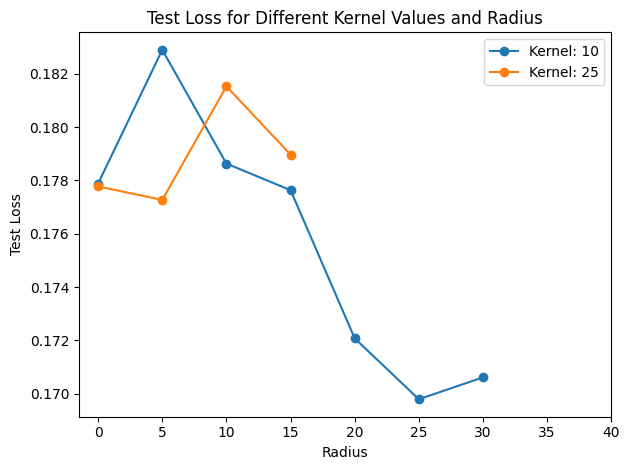

In [15]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the losses for each kernel value
kernel_losses = {}

# Iterate through the test_loss_rad_dict to populate kernel_losses
for radius, radius_losses in sorted(test_loss_rad_dict.items()):
    for kernel, loss in radius_losses.items():
        if kernel not in kernel_losses:
            kernel_losses[kernel] = []
        kernel_losses[kernel].append((radius, loss))

# Plot the losses for each kernel value
for kernel, losses in kernel_losses.items():
    radii, losses = zip(*losses)  # Unpack the list of tuples into two separate tuples
    plt.plot(radii, losses, label=f"Kernel: {kernel}", marker='o')

plt.xlabel("Radius")
plt.ylabel("Test Loss")
plt.title("Test Loss for Different Kernel Values and Radius")
plt.xticks(range(0, 41, 5))  # Adjust x-axis tick marks to be less frequent
plt.legend()
plt.tight_layout()

In [16]:
losses

(0.17777419090270996,
 0.17726539075374603,
 0.1815287470817566,
 0.17896780371665955)

In [17]:
test_loss_rad_dict = {}

ckpt_dir = "/nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDenseXenium"

# Iterate through all files in the directory
for filename in os.listdir(ckpt_dir):
    # Check if the file is a checkpoint file
    if filename.endswith('.ckpt'):
        model_name, hidden_layers, num_kernels, radius, run_name, optim, num_splits = filename.split("__")
        num_splits = num_splits.removesuffix(".ckpt")
        num_splits = num_splits.removeprefix("NUM_SPLITS=")
        if "[512, 512, 512]" not in hidden_layers or "POLAR_AND" not in run_name or int(radius) != 0 or int(num_kernels) != 10:
            continue
        with initialize(config_path="../config"):
            # try:
                try:
                    cfg_from_terminal = compose(config_name="configXenium")
                    OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
                    OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", int(num_kernels))
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", eval(hidden_layers))
                    OmegaConf.update(cfg_from_terminal, "training.logger_name", run_name)
                    OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
                    OmegaConf.update(cfg_from_terminal, "radius", int(radius))
                    OmegaConf.update(cfg_from_terminal, "gpus", [1])
                    OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", int(num_splits))
                    print(cfg_from_terminal.training.filepath)
                    # Check if the key already exists in the dictionary
                    if int(radius) in test_loss_rad_dict and int(num_kernels) in test_loss_rad_dict[int(radius)]:
                        print(f"Key ({int(radius)}, {int(num_kernels)}) already exists. Skipping test.")
                        continue
                    output = test(cfg_from_terminal)
                    trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
                    # Store the results over (radius, num_kernels) in a nested dict
                    if int(radius) not in test_loss_rad_dict:
                        test_loss_rad_dict[int(radius)] = {}
                    test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_BASE[0]['test_loss']
                except Exception as e:
                    if "CUDA out of memory" in str(e):
                        OmegaConf.update(cfg_from_terminal, "training.filepath", "${model.name}__${model.kwargs.kernel_size}__${radius}__${training.logger_name}__${optimizer.name}__NUM_SPLITS=" + str(num_splits))
                        OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 5)
                        print("Increasing splits to 5 due to OOM error.")
                        output = test(cfg_from_terminal)
                        trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
                        # Store the results over (radius, num_kernels) in a nested dict
                        if int(radius) not in test_loss_rad_dict:
                            test_loss_rad_dict[int(radius)] = {}
                        test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_BASE[0]['test_loss']
                    else:
                        raise e


MonetDense__[512, 512, 512]__10__0__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 0 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17787978053092957    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

In [18]:
test_loss_rad_dict = {}

ckpt_dir = "/nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDenseXenium"

# Iterate through all files in the directory
for filename in os.listdir(ckpt_dir):
    # Check if the file is a checkpoint file
    if filename.endswith('.ckpt'):
        model_name, hidden_layers, num_kernels, radius, run_name, optim, num_splits = filename.split("__")
        num_splits = num_splits.removesuffix(".ckpt")
        num_splits = num_splits.removeprefix("NUM_SPLITS=")
        if "[512, 512, 512]" not in hidden_layers or "POLAR_AND" not in run_name or int(radius) != 30 or int(num_kernels) != 10:
            continue
        with initialize(config_path="../config"):
            # try:
                try:
                    cfg_from_terminal = compose(config_name="configXenium")
                    OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
                    OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", int(num_kernels))
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", eval(hidden_layers))
                    OmegaConf.update(cfg_from_terminal, "training.logger_name", run_name)
                    OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
                    OmegaConf.update(cfg_from_terminal, "radius", int(radius))
                    OmegaConf.update(cfg_from_terminal, "gpus", [1])
                    OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", int(num_splits))
                    print(cfg_from_terminal.training.filepath)
                    # Check if the key already exists in the dictionary
                    if int(radius) in test_loss_rad_dict and int(num_kernels) in test_loss_rad_dict[int(radius)]:
                        print(f"Key ({int(radius)}, {int(num_kernels)}) already exists. Skipping test.")
                        continue
                    output = test(cfg_from_terminal)
                    trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                    # Store the results over (radius, num_kernels) in a nested dict
                    if int(radius) not in test_loss_rad_dict:
                        test_loss_rad_dict[int(radius)] = {}
                    test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_SPATIAL[0]['test_loss']
                except Exception as e:
                    if "CUDA out of memory" in str(e):
                        OmegaConf.update(cfg_from_terminal, "training.filepath", "${model.name}__${model.kwargs.kernel_size}__${radius}__${training.logger_name}__${optimizer.name}__NUM_SPLITS=" + str(num_splits))
                        OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 5)
                        print("Increasing splits to 5 due to OOM error.")
                        output = test(cfg_from_terminal)
                        trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                        # Store the results over (radius, num_kernels) in a nested dict
                        if int(radius) not in test_loss_rad_dict:
                            test_loss_rad_dict[int(radius)] = {}
                        test_loss_rad_dict[int(radius)][int(num_kernels)] = test_results_SPATIAL[0]['test_loss']
                    else:
                        raise e


MonetDense__[512, 512, 512]__10__30__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 30 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.16925674676895142    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

In [19]:
NON_RESPONSE_FILE = "../spatial/non_response_blank_removed_xenium.txt"
with open(NON_RESPONSE_FILE, "r", encoding="utf-8") as f:
    non_response_genes = f.read().split(',')

non_response_genes = [int(x) for x in non_response_genes]

xenium_df = pd.read_csv("../data/raw/xenium.csv", index_col="cell_id")
 
location_names = ["x_location", "y_location", "z_location", "qv"]

non_response_gene_names = xenium_df.columns[non_response_genes]
# First, combine non_response_gene_names and location_names into a single list
response_gene_names = xenium_df.columns[~xenium_df.columns.isin(non_response_gene_names | location_names)]
combined_names = list(non_response_gene_names) + location_names
# Then, use the ~ operator to get the indexes of columns that are not in the combined list
response_gene_indexes = (~xenium_df.columns.isin(combined_names)).nonzero()[0]


/tmp/ipykernel_2588776/4044879647.py:13: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  response_gene_names = xenium_df.columns[~xenium_df.columns.isin(non_response_gene_names | location_names)]


In [20]:
assert ','.join(xenium_df.columns[response_gene_indexes]) == ','.join(response_gene_names), "Response genes don't line up"

In [21]:
rad = 30
loss_dict = {rad: {}}
for i, gene in enumerate(response_gene_names):
    inputs_SPATIAL_responses = inputs_SPATIAL[:, response_gene_indexes]
    loss_dict[rad][gene] = {"base": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_BASE[:, i]) ** 2 ).item(), "spatial": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_SPATIAL[:, i]) ** 2 ).item()}
    loss_dict[rad][gene]["diff"] = loss_dict[rad][gene]["spatial"] - loss_dict[rad][gene]["base"]
    loss_dict[rad][gene]["percent_diff"] = (loss_dict[rad][gene]["diff"]/loss_dict[rad][gene]["base"]) * 100.0
    loss_dict[rad][gene]["sparsity"] = (inputs_SPATIAL_responses[:, i] == 0).float().mean()

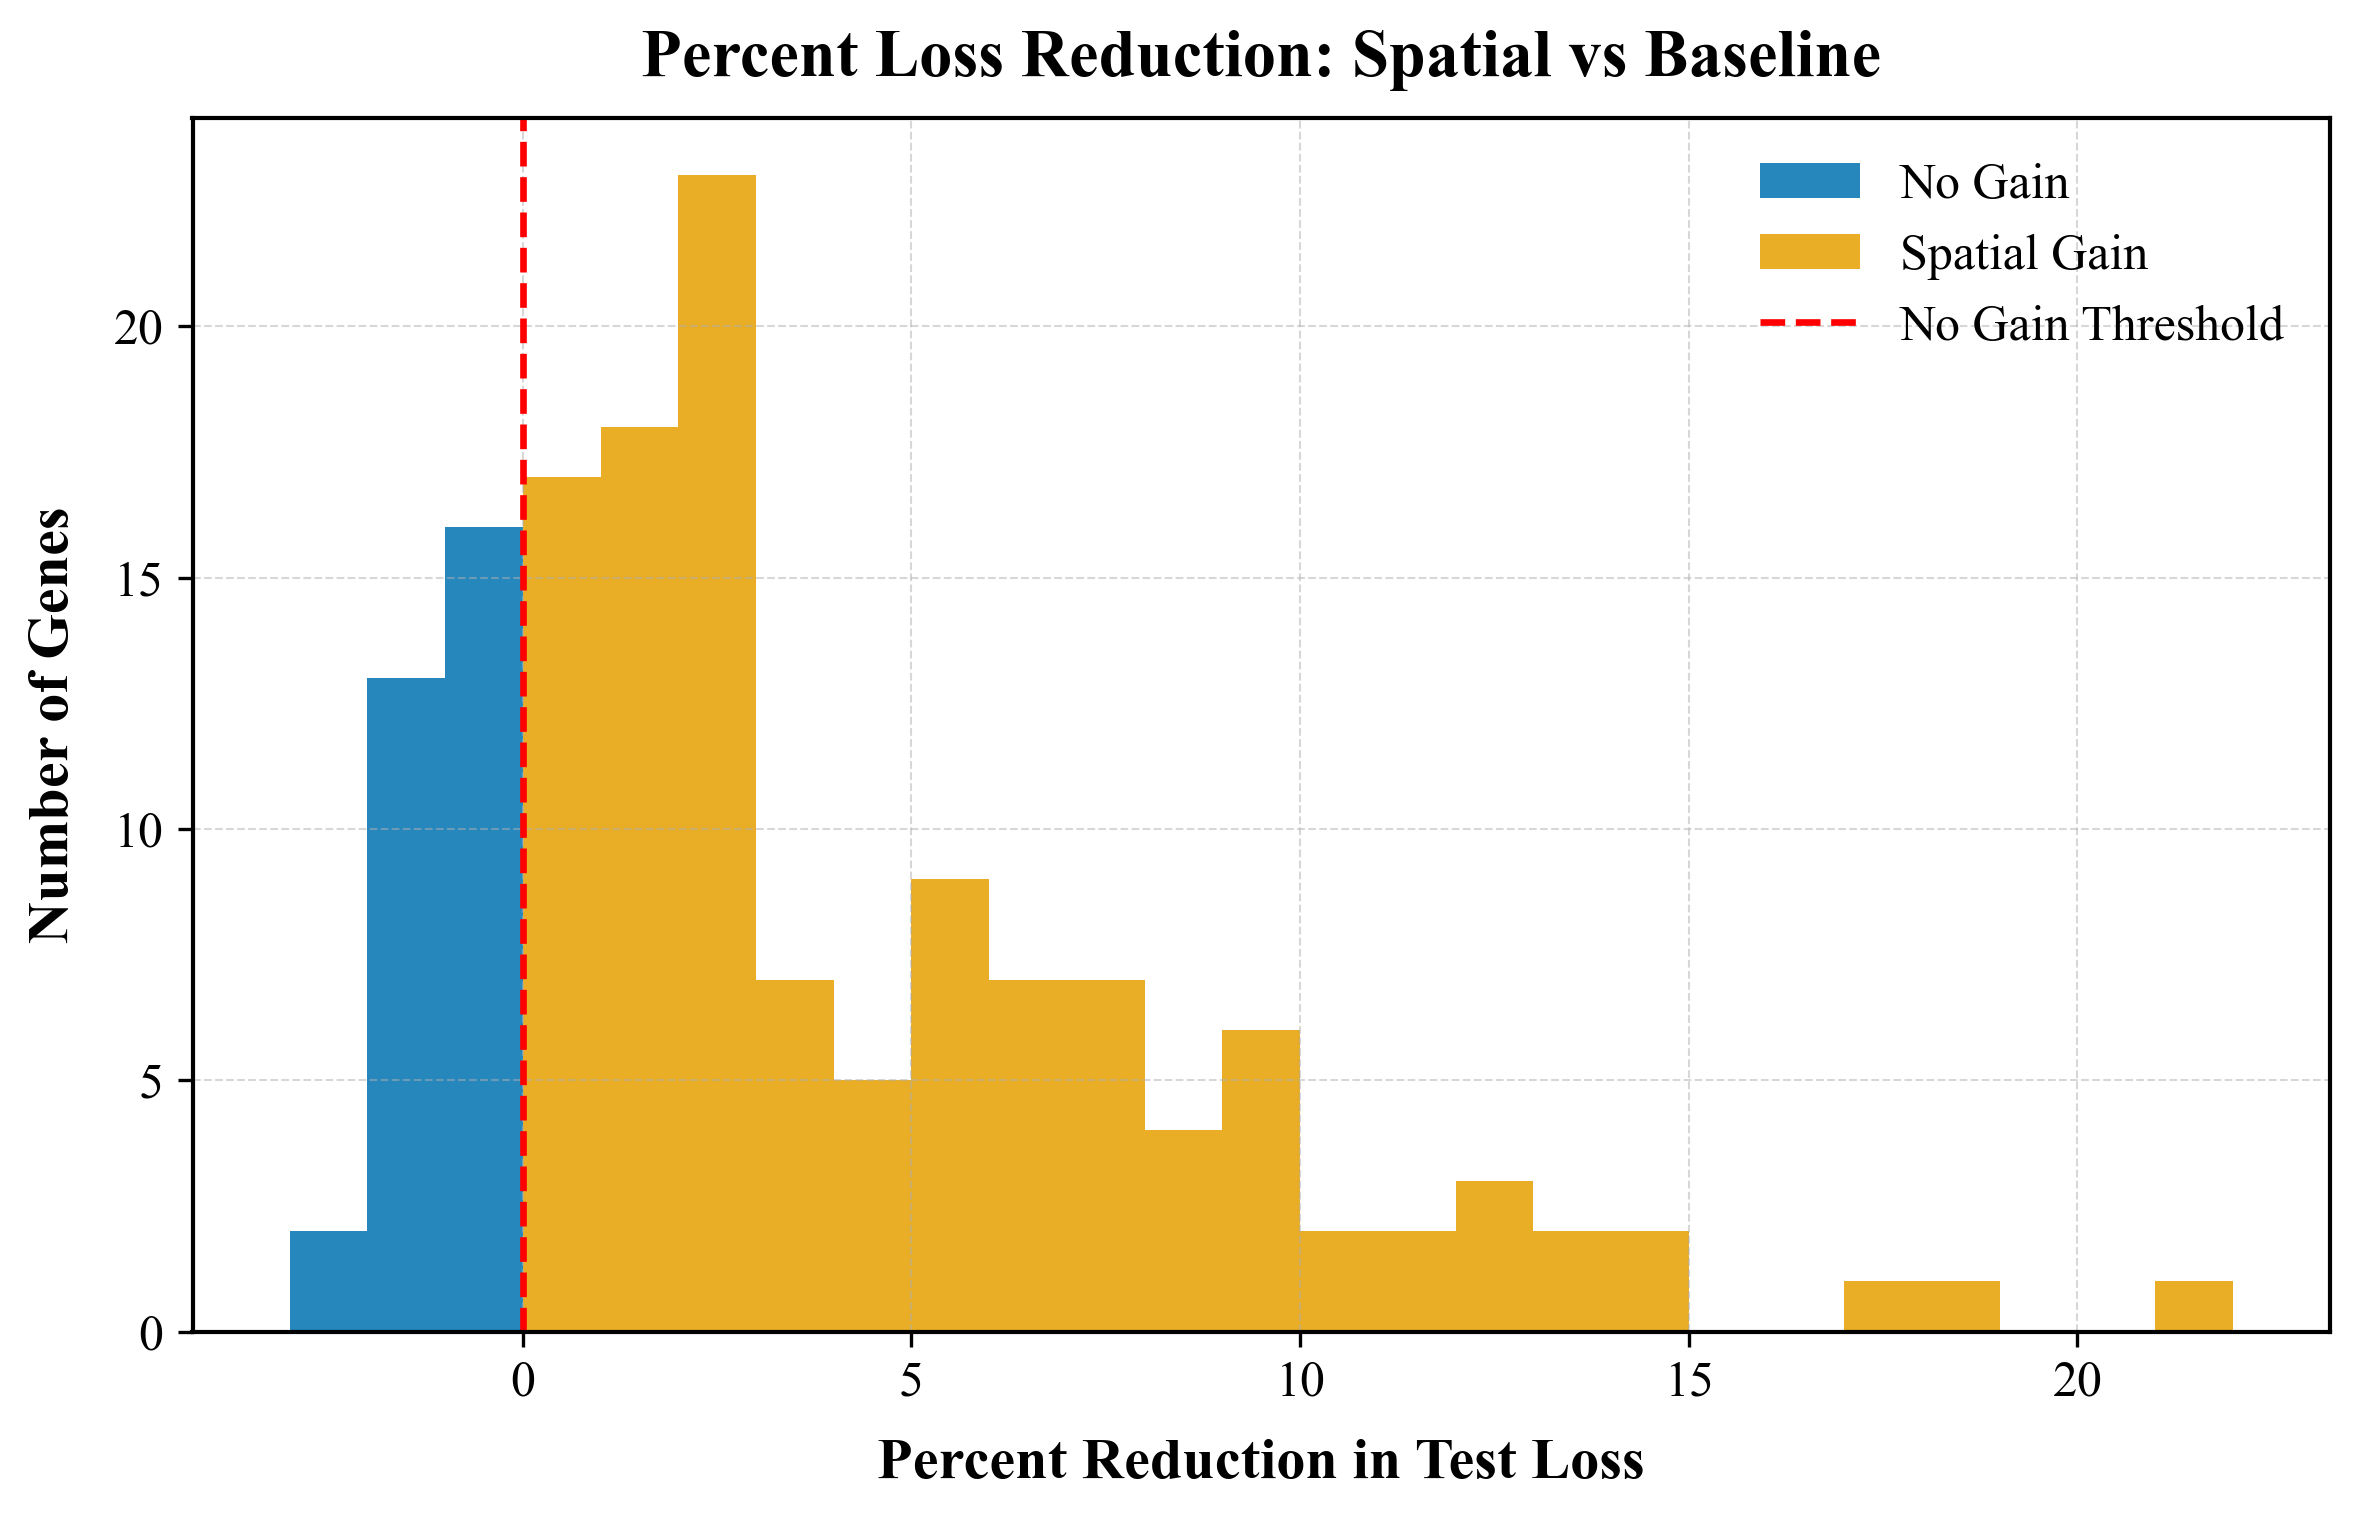

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# ICML-style font + layout with bold title and axes
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.0,
    "figure.dpi": 300  # High DPI for high-quality output
})

# Data prep
percent_differences = np.array([-loss_dict[30][x]["percent_diff"] for x in loss_dict[30]])

# Define bin edges
bin_width = 1
bins = np.arange(np.floor(percent_differences.min()), np.ceil(percent_differences.max()) + bin_width, bin_width)

# Split bins <0 and >=0
neg_values = percent_differences[percent_differences < 0]
pos_values = percent_differences[percent_differences >= 0]

# Plot
fig, ax = plt.subplots(figsize=(8, 5.2))

# Colorblind-safe colors
color_neg = "#0072B2"  # blue
color_pos = "#E69F00"  # orange

# Histograms
ax.hist(neg_values, bins=bins, color=color_neg, alpha=0.85, label="No Gain")
ax.hist(pos_values, bins=bins, color=color_pos, alpha=0.85, label="Spatial Gain")

# Vertical line at 0%
ax.axvline(0, color='red', linestyle='--', linewidth=1.6, label="No Gain Threshold")

# Labels and legend
ax.set_title("Percent Loss Reduction: Spatial vs Baseline", pad=10, fontweight='bold')  # Bold title
ax.set_xlabel("Percent Reduction in Test Loss", labelpad=8, fontweight='bold')  # Bold x-axis label
ax.set_ylabel("Number of Genes", labelpad=8, fontweight='bold')  # Bold y-axis label
ax.legend(loc="upper right", frameon=False)  # Bold legend

# Grid + layout
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
fig.tight_layout(pad=1.2)

# Optional save
fig.savefig("xenium_spatial_vs_baseline.png", bbox_inches='tight', dpi=300)  # High DPI for high-quality output

plt.show()


In [23]:
# Rank genes based on their percent decrease and save in a dictionary
# First, let's create a dictionary with gene names as keys and their percent differences as values
gene_percent_diffs = {x: -loss_dict[30][x]["percent_diff"] for x in loss_dict[30]}

# Now, let's sort the genes based on their percent differences in descending order (largest decrease first)
sorted_genes = sorted(gene_percent_diffs, key=gene_percent_diffs.get, reverse=True)

# Print the top 10 genes with the largest percent decrease
print("Top 10 genes with the largest percent decrease:")
for gene in sorted_genes[:10]:
    print(f"{gene}: {gene_percent_diffs[gene]}% decrease")


Top 10 genes with the largest percent decrease:
Cabp7: 21.000175099196948% decrease
Gfap: 18.15722895004384% decrease
Arc: 17.217586307901087% decrease
Slc17a7: 14.929830870469345% decrease
Plcxd2: 14.52562364595301% decrease
Cux2: 13.600559071352766% decrease
Igfbp5: 13.508440813021993% decrease
Cplx3: 12.918853804588718% decrease
Lamp5: 12.491105069197216% decrease
Cpne4: 12.14853353746305% decrease


In [24]:
positive_decrease_genes = sum(1 for gene in gene_percent_diffs if gene_percent_diffs[gene] > 0)
total_genes = len(gene_percent_diffs)
percentage_positive_decrease = (positive_decrease_genes / total_genes) * 100

print(f"Percentage of genes with a positive decrease: {percentage_positive_decrease:.2f}%")

Percentage of genes with a positive decrease: 79.05%


In [25]:
# First, let's sort the genes based on their percent differences in descending order (largest decrease first)
sorted_genes = sorted(loss_dict[30], key=lambda gene: -loss_dict[30][gene]["percent_diff"], reverse=True)

# Now, iterate through each gene in the sorted order
for gene in sorted_genes:
    # Extract percent difference and sparsity for each gene
    percent_diff = loss_dict[30][gene]["percent_diff"]
    sparsity = loss_dict[30][gene]["sparsity"]
    
    # Print the gene name, percent difference, and sparsity in descending order of percent difference
    print(f"Gene Name: {gene}, Percent Difference: {percent_diff}%, Sparsity: {sparsity}")


Gene Name: Cabp7, Percent Difference: -21.000175099196948%, Sparsity: 0.5356360673904419
Gene Name: Gfap, Percent Difference: -18.15722895004384%, Sparsity: 0.47545868158340454
Gene Name: Arc, Percent Difference: -17.217586307901087%, Sparsity: 0.1426519751548767
Gene Name: Slc17a7, Percent Difference: -14.929830870469345%, Sparsity: 0.13805608451366425
Gene Name: Plcxd2, Percent Difference: -14.52562364595301%, Sparsity: 0.33409932255744934
Gene Name: Cux2, Percent Difference: -13.600559071352766%, Sparsity: 0.34641486406326294
Gene Name: Igfbp5, Percent Difference: -13.508440813021993%, Sparsity: 0.248105987906456
Gene Name: Cplx3, Percent Difference: -12.918853804588718%, Sparsity: 0.7616243362426758
Gene Name: Lamp5, Percent Difference: -12.491105069197216%, Sparsity: 0.3536677360534668
Gene Name: Cpne4, Percent Difference: -12.14853353746305%, Sparsity: 0.45448997616767883
Gene Name: Meis2, Percent Difference: -11.389239067381297%, Sparsity: 0.23675990104675293
Gene Name: Rorb, Pe

In [26]:
loss_dict

{30: {'2010300C02Rik': {'base': 0.2262457165810099,
   'spatial': 0.20517169458077225,
   'diff': -0.02107402200023764,
   'percent_diff': -9.314661209372264,
   'sparsity': tensor(0.2145)},
  'Acsbg1': {'base': 0.29025395858721953,
   'spatial': 0.28355428413277267,
   'diff': -0.006699674454446858,
   'percent_diff': -2.3082112254581526,
   'sparsity': tensor(0.2274)},
  'Acta2': {'base': 0.1471590345018459,
   'spatial': 0.13728382118887947,
   'diff': -0.009875213312966424,
   'percent_diff': -6.710572236625101,
   'sparsity': tensor(0.7601)},
  'Adamtsl1': {'base': 0.08689044525469909,
   'spatial': 0.0871000748612457,
   'diff': 0.00020962960654660745,
   'percent_diff': 0.2412573740785044,
   'sparsity': tensor(0.8408)},
  'Aldh1a2': {'base': 0.03419534165168982,
   'spatial': 0.03482265633315531,
   'diff': 0.000627314681465492,
   'percent_diff': 1.8345033304689684,
   'sparsity': tensor(0.9143)},
  'Arc': {'base': 0.30387189134981096,
   'spatial': 0.25155248619120585,
   'di

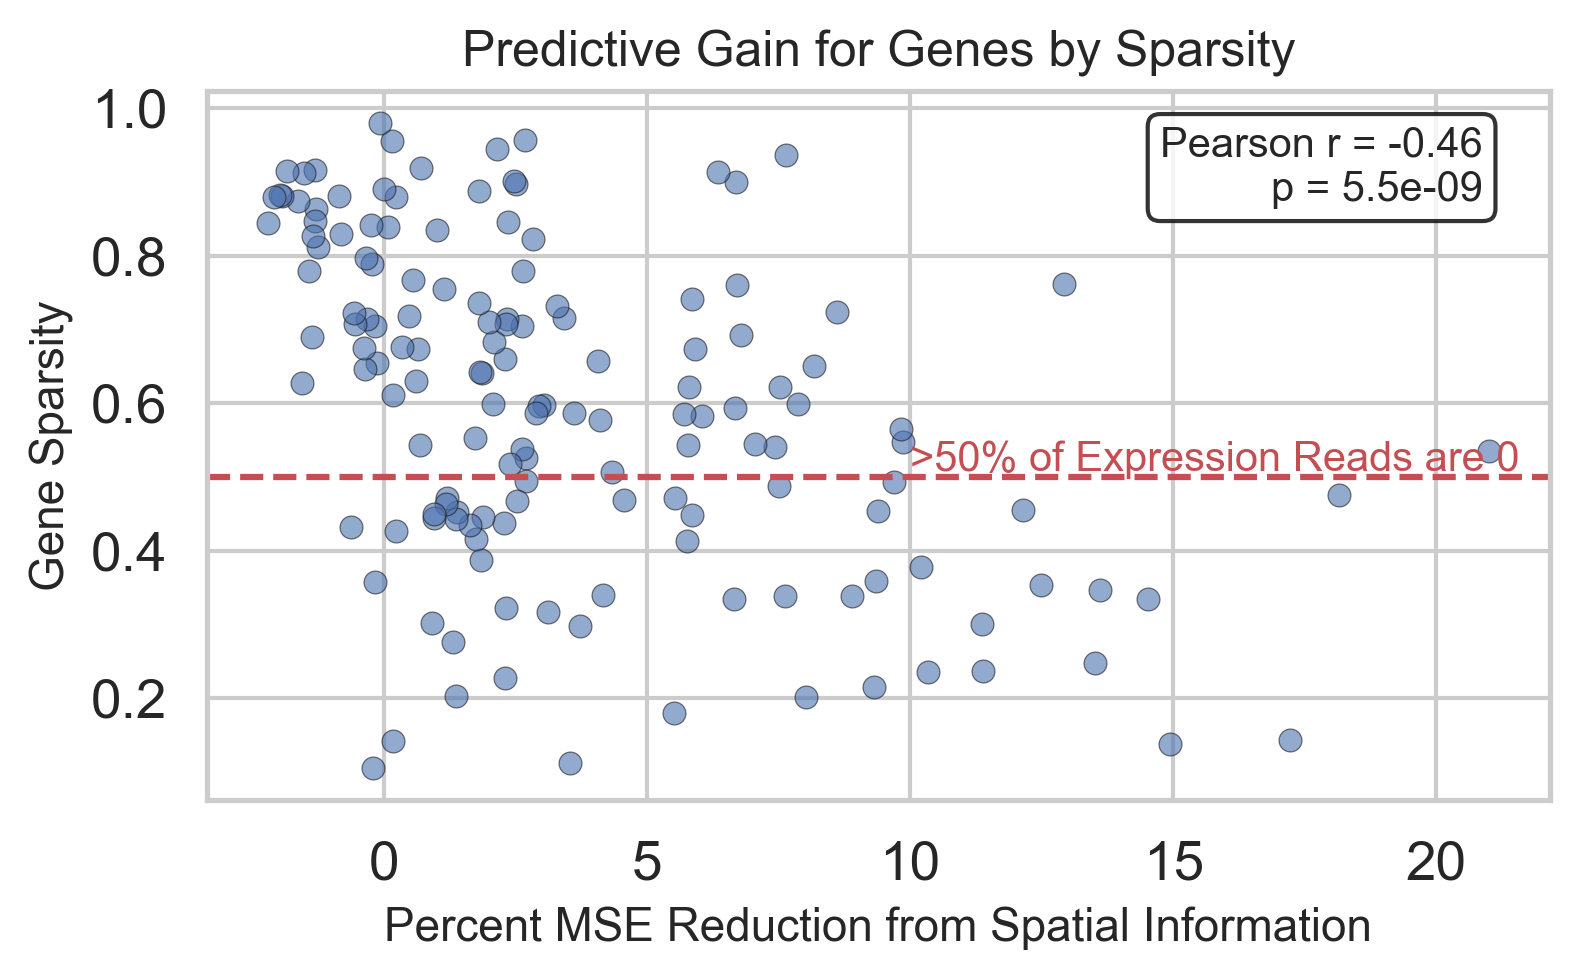

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Extract percent differences and sparsity for each gene
percent_diffs = np.array([-loss_dict[30][gene]["percent_diff"] for gene in sorted_genes])
sparsities = np.array([loss_dict[30][gene]["sparsity"] for gene in sorted_genes])

# Compute Pearson correlation
corr, pval = pearsonr(percent_diffs, sparsities)

# Create plot
sns.set(style="whitegrid", font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5, 3.5))
scatter = ax.scatter(percent_diffs, sparsities, alpha=0.6, edgecolor='k', linewidth=0.3, s=30)

# Axis labels and title
ax.set_title("Predictive Gain for Genes by Sparsity", fontsize=12)
ax.set_xlabel("Percent MSE Reduction from Spatial Information", fontsize=11)
ax.set_ylabel("Gene Sparsity", fontsize=11)

# Add horizontal line at y=0.5
ax.axhline(y=0.5, color='r', linestyle='--')

# Add caption for the horizontal line
ax.text(10, 0.55, ">50% of Expression Reads are 0", fontsize=10, color='r', verticalalignment='top')

# Add correlation in a box
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8)
ax.text(0.95, 0.95,
        f"Pearson r = {corr:.2f}\np = {pval:.1e}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=bbox_props)

plt.tight_layout()
plt.savefig('sparsity_scatter_Xenium.png')
plt.show()


In [28]:
test_loss_rad_dict = {}
loss_dict = {}

ckpt_dir = "/nfs/turbo/lsa-regier/scratch/roko/output/lightning_logs/checkpoints/MonetDenseXenium"

# Iterate through all files in the directory
for filename in os.listdir(ckpt_dir):
    # Check if the file is a checkpoint file
    if filename.endswith('.ckpt'):
        model_name, hidden_layers, num_kernels, radius, run_name, optim, num_splits = filename.split("__")
        num_splits = num_splits.removesuffix(".ckpt")
        num_splits = num_splits.removeprefix("NUM_SPLITS=")
        if "[512, 512, 512]" not in hidden_layers or "POLAR_AND" not in run_name or int(num_kernels) != 10:
            continue
        with initialize(config_path="../config"):
            # try:
                try:
                    cfg_from_terminal = compose(config_name="configXenium")
                    OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
                    OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", int(num_kernels))
                    OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", eval(hidden_layers))
                    OmegaConf.update(cfg_from_terminal, "training.logger_name", run_name)
                    OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
                    OmegaConf.update(cfg_from_terminal, "radius", int(radius))
                    OmegaConf.update(cfg_from_terminal, "gpus", [1])
                    OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", int(num_splits))
                    print(cfg_from_terminal.training.filepath)
                    # Check if the key already exists in the dictionary
                    if int(radius) in test_loss_rad_dict:
                        print(f"Key ({int(radius)}, {int(num_kernels)}) already exists. Skipping test.")
                        continue
                    output = test(cfg_from_terminal)
                    trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                    # Store the results over (radius, num_kernels) in a nested dict
                    if int(radius) not in test_loss_rad_dict:
                        test_loss_rad_dict[int(radius)] = {}
                    test_loss_rad_dict[int(radius)] = test_results_SPATIAL[0]['test_loss']
                except Exception as e:
                    if "CUDA out of memory" in str(e):
                        OmegaConf.update(cfg_from_terminal, "training.filepath", "${model.name}__${model.kwargs.kernel_size}__${radius}__${training.logger_name}__${optimizer.name}__NUM_SPLITS=" + str(num_splits))
                        OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 5)
                        print("Increasing splits to 5 due to OOM error.")
                        output = test(cfg_from_terminal)
                        trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                        # Store the results over (radius, num_kernels) in a nested dict
                        if int(radius) not in test_loss_rad_dict:
                            test_loss_rad_dict[int(radius)] = {}
                        test_loss_rad_dict[int(radius)] = test_results_SPATIAL[0]['test_loss']
                    else:
                        raise e
    loss_dict[radius] = {}
    for i, gene in enumerate(response_gene_names):
        inputs_SPATIAL_responses = inputs_SPATIAL[:, response_gene_indexes]
        loss_dict[radius][gene] = {"base": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_BASE[:, i]) ** 2 ).item(), "spatial": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_SPATIAL[:, i]) ** 2 ).item()}
        loss_dict[radius][gene]["diff"] = loss_dict[radius][gene]["spatial"] - loss_dict[radius][gene]["base"]
        loss_dict[radius][gene]["percent_diff"] = (loss_dict[radius][gene]["diff"]/loss_dict[radius][gene]["base"]) * 100.0


/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


MonetDense__[512, 512, 512]__10__10__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 10 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17862939834594727    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__0__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 0 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17787978053092957    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__5__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


The number of parameters for radius 5 is 7817172


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17754530906677246    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__20__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 20 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17207391560077667    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__25__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 25 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.16978922486305237    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__30__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.
The number of parameters for radius 30 is 7817172


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.16925674676895142    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

MonetDense__[512, 512, 512]__10__15__POLAR_AND_DEGREE__Adam__NUM_SPLITS=3
There are 64 graph splits for the Xenium Dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


The number of parameters for radius 15 is 7817172


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17702952027320862    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  182            	

In [29]:
loss_dict

{'10': {'2010300C02Rik': {'base': 0.2262457165810099,
   'spatial': 0.22628197289750768,
   'diff': 3.625631649778471e-05,
   'percent_diff': 0.016025194662548547},
  'Acsbg1': {'base': 0.29025395858721953,
   'spatial': 0.289309893336289,
   'diff': -0.000944065250930548,
   'percent_diff': -0.32525490970930626},
  'Acta2': {'base': 0.1471590345018459,
   'spatial': 0.15014523288685477,
   'diff': 0.0029861983850088814,
   'percent_diff': 2.0292321128074704},
  'Adamtsl1': {'base': 0.08689044525469909,
   'spatial': 0.08659487138105207,
   'diff': -0.00029557387364702314,
   'percent_diff': -0.3401684417436431},
  'Aldh1a2': {'base': 0.03419534165168982,
   'spatial': 0.03517753393165242,
   'diff': 0.0009821922799626015,
   'percent_diff': 2.8722984842997317},
  'Arc': {'base': 0.30387189134981096,
   'spatial': 0.298260825597432,
   'diff': -0.005611065752378963,
   'percent_diff': -1.8465234567943707},
  'Arhgap12': {'base': 0.21604223552801013,
   'spatial': 0.21582380313276522,
 

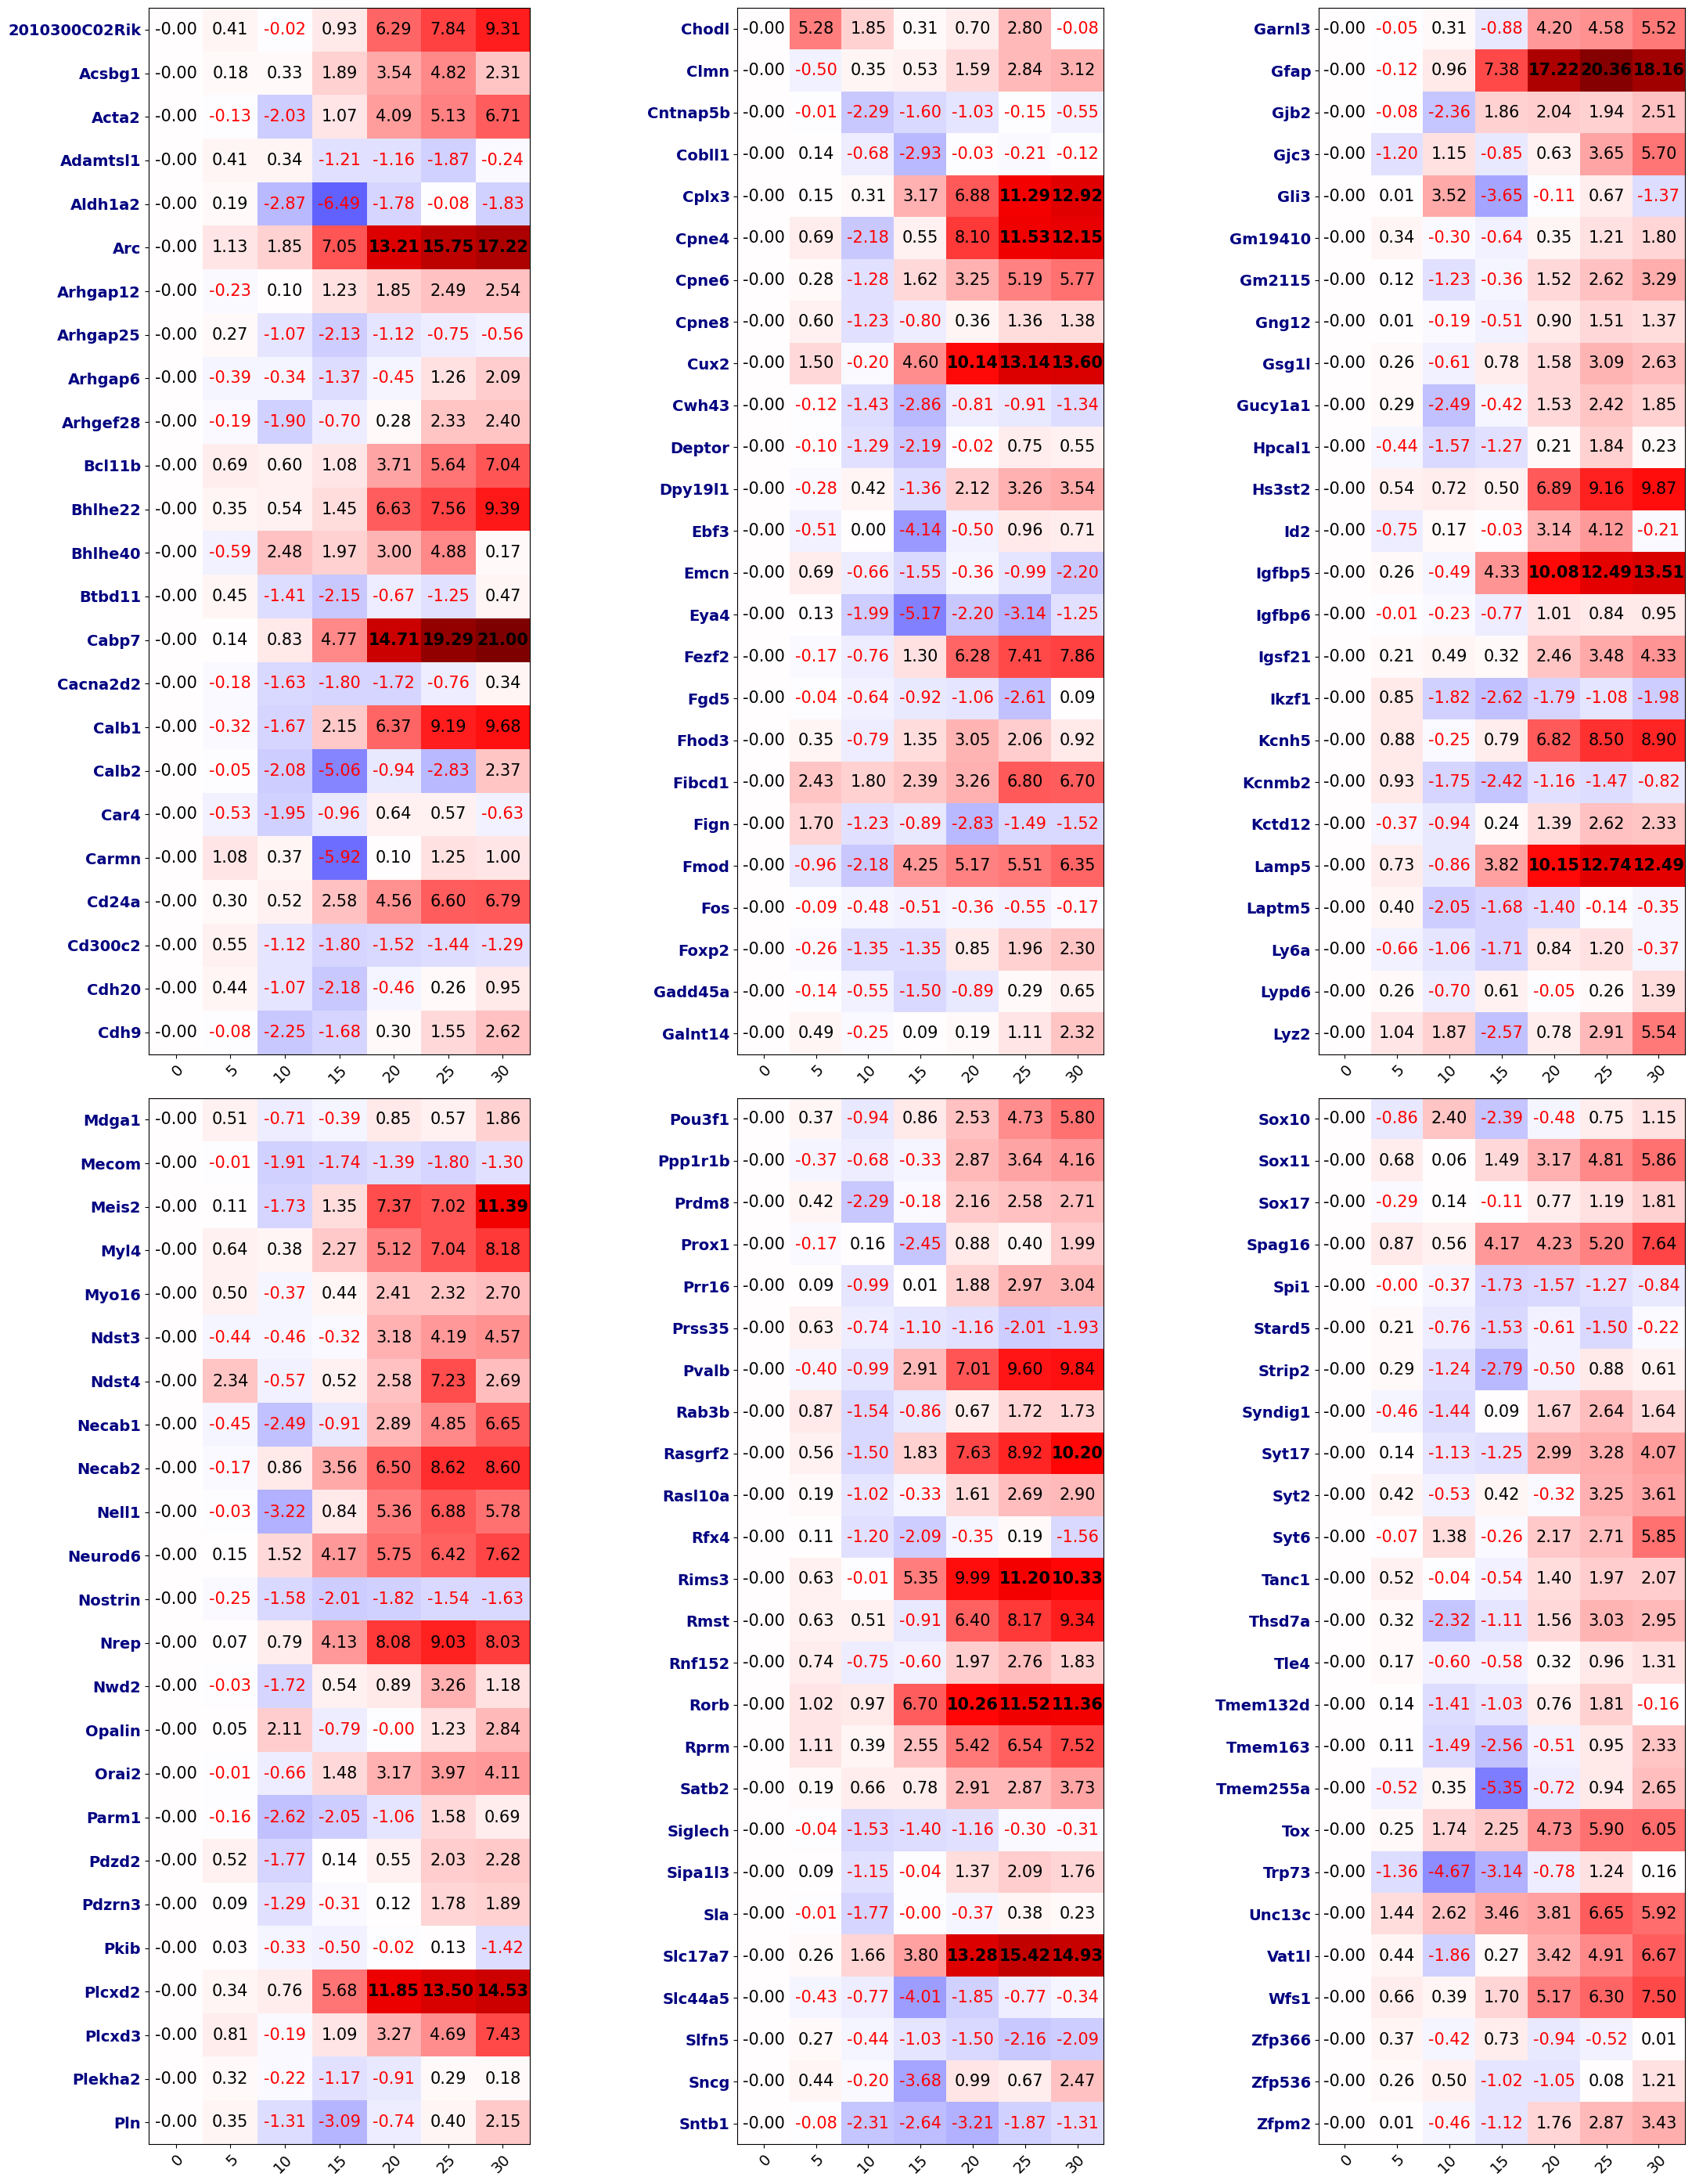

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import json


plt.style.use('default')

# Assuming these variables are defined elsewhere in your code
# radius_values, genes, data, response_indexes

fig, axes = plt.subplots(2, 3, figsize=(24, 28))

quarter = 0

# Initialize an empty array to store the full loss data
full_loss_array = np.array([])

for ax in axes.ravel():
    
    quarter += 1
    radius_values = list(range(0, 31, 5))
    n = len(response_gene_indexes)
    genes = response_gene_names[n * (quarter - 1) // 6 : n * quarter // 6]
    
    # Initialize an empty array to store the loss data for the current quarter
    loss_array = np.array([])
    
    # Loop through each gene and radius to build the loss array
    for gene in genes:
        for rad in radius_values:
            # Extract the percent difference for the current gene and radius
            percent_diff = loss_dict[str(rad)][gene]["percent_diff"]
            # Append the negative of the percent difference to the loss array
            loss_array = np.append(loss_array, -percent_diff)
    
    # Reshape the loss array to match the dimensions of the genes and radius values
    loss_array = loss_array.reshape(len(genes), len(radius_values))
    
    # If this is the first quarter, initialize the full_loss_array
    if full_loss_array.size == 0:
        full_loss_array = loss_array.T
    else:
        # Append the current loss array to the full loss array
        full_loss_array = np.append(full_loss_array, loss_array.T, axis=1)
    
    # Plotting the loss array
    im = ax.imshow(loss_array, cmap='seismic', 
                   vmin=-np.max(np.abs(full_loss_array)), 
                   vmax=np.max(np.abs(full_loss_array)))
    
    # Adjusting the aspect ratio to make cells wider horizontally
    ax.set_aspect(0.8)
    
    # Setting x-axis ticks and labels with a label size of 10
    ax.set_xticks(np.arange(len(radius_values)))
    ax.set_xticklabels(list(radius_values), fontsize=14)
    
    # Setting y-axis ticks and labels with a custom font dict
    gene_font = {'fontsize': 14, 'fontweight': 'bold', 'color': 'navy'}  # Increased font size for gene names
    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes, fontdict=gene_font)
    
    # Adjusting tick font sizes for both axes
    ax.tick_params(axis='both', which='major')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Dynamically adjusting text color and font weight based on cell value
    for i in range(len(genes)):
        for j in range(len(radius_values)):
            text_color = 'red' if loss_array[i, j] < 0 else 'black'
            # Making text bold if the loss is greater than 10 (adjust the condition as needed)
            fontweight = 'bold' if loss_array[i, j] > 10 else 'normal'
            ax.text(j, i, f"{loss_array[i, j]:.2f}",
                    ha="center", va="center", color=text_color,
                    fontsize=15, fontweight=fontweight)

fig.tight_layout(w_pad=0.5)  # Adjusting the width padding to move columns closer together
plt.savefig("spatial_vertical_full_Xenium.png", dpi=600)
plt.show()